In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import Angle

import pickle
import pandas as pd

coord.galactocentric_frame_defaults.set('v4.0')
import galstreams
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [2]:
gsr = coord.Galactocentric()
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [3]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields) #0.97483 
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])

In [4]:
h = 0.7
ts = Table(subhalos_z0)
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [5]:
ind_massive = (ts['mvir'] > 10**7)
len(ts['mvir'][ind_massive])

1072

In [6]:
c = coord.Galactocentric(x=ts['x'][ind_massive], y=ts['y'][ind_massive], z=ts['z'][ind_massive],
                         v_x=ts['vx'][ind_massive], v_y=ts['vy'][ind_massive], v_z=ts['vz'][ind_massive])
ceq = c.transform_to(coord.ICRS()) 

ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric()) #galactocentric coordinates

In [7]:
vsim = np.array([c.x.value[ind_lmc], c.y.value[ind_lmc], c.z.value[ind_lmc]]) #this is the u vector 
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value]) #this is the v vector 
vtrue = vtrue / np.linalg.norm(vtrue)

vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [8]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

#ROTATION MATRIX
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [9]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

for i in range(N):
    temp_vec = np.array([ts['x'][ind_massive][i], ts['y'][ind_massive][i], ts['z'][ind_massive][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc

In [10]:
#This is the radius from the center at which the maximum velocity occurs
trot['rs'] = (trot['RVmax'])/2.163

In [11]:
subhalo_dist=np.sqrt(trot['x']**2+trot['y']**2+trot['z']**2)

In [12]:
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))


In [13]:
#Getting the Orbits of Subhalos
dt = 1*u.Myr
subh_orbits = []
Nstep_long=3000
for subh in range(len(ts['x'][ind_massive])): 
    #This calculates the position of the subhalos at a given time
    c_subh = coord.Galactocentric(x=ts['x'][ind_massive][subh]*u.kpc, y=ts['y'][ind_massive][subh]*u.kpc, 
                                  z=ts['z'][ind_massive][subh]*u.kpc,
                                  v_x=ts['vx'][ind_massive][subh]*u.km/u.s, 
                                  v_y=ts['vy'][ind_massive][subh]*u.km/u.s,
                                  v_z=ts['vz'][ind_massive][subh]*u.km/u.s)
    w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
    subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]

In [14]:
#Rotating Subhalo Orbits 
N = len(subh_orbits[0].pos.x)

rot_orbits=np.zeros((len(ts['x'][ind_massive]), len(subh_orbits[1].pos.x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
        rot_vec = np.matmul(R, temp_vec)

        rot_orbits[j][i][0] = rot_vec[0]
        rot_orbits[j][i][1] = rot_vec[1]
        rot_orbits[j][i][2] = rot_vec[2]

In [15]:
len(rot_orbits)

1072

In [16]:
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)


In [17]:
len(r_peri)

41

In [18]:
r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)


In [ ]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

#Information for Gaia-1
c_gaia1 = coord.SkyCoord(ra=190.96*u.deg, dec=-9.16*u.deg, distance=5.57*u.kpc, pm_ra_cosdec=-14.39*u.mas/u.yr,
                  pm_dec=-19.72*u.mas/u.yr, radial_velocity=214.91*u.km/u.s, frame='icrs')

w0_gaia1 = gd.PhaseSpacePosition(c_gaia1.transform_to(gc_frame).cartesian)

In [ ]:
dt = 1*u.Myr
Nstep_foward = 2
orbit_foward_gaia1 = ham.integrate_orbit(w0_gaia1, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs_gaia1 = orbit_foward_gaia1.to_coord_frame(coord.ICRS())

In [ ]:
w0_start_gaia1 = gd.PhaseSpacePosition(orbit_foward_gaia1.pos[-1], orbit_foward_gaia1.vel[-1])
Nstep = 7
orbit_gaia1 = ham.integrate_orbit(w0_start_gaia1, dt=-dt, n_steps=Nstep)
orbit_sky_gaia1 = orbit_gaia1.to_coord_frame(coord.ICRS())

In [ ]:
Nstep_long = 3000
orbit_long_gaia1 = ham.integrate_orbit(w0_start_gaia1, dt=-dt, n_steps=Nstep_long)

In [ ]:
closest_dist_Gaia1 = pd.DataFrame()
data_new = {'Stream':['Gaia-1']}
data_temp = pd.DataFrame(data=data_new)
for subh in range(len(trot['x'])): #subh stands for individual subhalo
    dist_x = orbit_long_gaia1.pos.x - rot_orbits[subh,:,0]*u.kpc 
    dist_y = orbit_long_gaia1.pos.y - rot_orbits[subh,:,1]*u.kpc
    dist_z = orbit_long_gaia1.pos.z - rot_orbits[subh,:,2]*u.kpc
    rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
    closest_dist = np.min(rel_dist)
    data_temp['Subhalo_'+ str(subh)+ ' (kpc)'] = [closest_dist.value]
closest_dist_Gaia1 = closest_dist_Gaia1.append(data_temp, ignore_index=True)


In [ ]:
closest_dist_Gaia1

In [ ]:
closest_dist_Gaia1;
closest_dist_Gaia1.to_csv('Gaia1_Rel_Dist_to_Subhalos.csv', index='False')

In [19]:
# initialize list of lists
data = [['Gjoll', 82.1, -13.95, 3.26, 23.58, -23.7, 78.73], 
        ['Leiptr', 89.11, -28.37, 7.39, 10.59, -9.9, 194.22],
        ['Hrid', 280.51, 33.3, 2.75, -5.88, 20.08, -238.77],
        ['Pal5', 229.65, 0.26, 20.16, -2.75, -2.68, -57.03],
        ['Gaia1', 190.96, -9.16, 5.57, -14.39, -19.72, 214.91],
        ['Ylgr', 173.82, -22.31, 9.72, -0.44, -7.65, 317.86],
        ['Fjorm', 251.89, 65.38, 6.42, 3.92, 3.1, -25.37],
        ['Kshir', 205.88, 67.25, 9.57, -7.67, -3.92, -249.88],
        ['Gunnthra', 284.22, -73.49, 2.83, -15.83, -24.04, 132.26],
        ['Slidr', 160.05, 10.22, 2.99, -24.6, -6.65, 87.98],
        ['M92', 259.89, 43.08, 8.94, -5.15, -0.63, -140.66],
        ['NGC3201', 152.46, -46.32, 4.99, 8.87, -2.22, 489.63],
        ['Atlas', 25.04, -29.81, 19.93, 0.04, -0.89, -85.65],
        ['C7', 287.15, -50.17, 6.77, -13.79, -12.38, 55.05],
        ['Palca', 36.57, -36.15, 12.31, 0.9, -0.23, 106.32],
        ['Sylgr', 179.68, -2.44, 3.77, -13.98, -12.9, -184.8],
        ['Gaia9', 233.27, 60.42, 4.68, -12.49, 6.37, -359.86],
        ['Gaia10', 161.47, 15.17, 13.32, -4.14, -3.15, 289.62],
        ['Gaia12', 41.05, 16.45, 15.71, 5.84, -5.66, -303.83],
        ['Indus', 340.12, -60.58, 14.96, 3.59, -4.89, -49.15],
        ['Jhelum', 351.95, -51.74, 11.39, 7.23, -4.37, -1.29],
        ['Phoenix', 23.96, -50.01, 16.8, 2.72, -0.07, 45.92],
        ['NGC5466', 214.41, 26.84, 14.09, -5.64, -0.72, 95.04],
        ['M5', 206.96, 13.5, 7.44, 3.5, -8.76, -42.97],
        ['C20', 359.81, 8.63, 18.11, -0.58, 1.44, -116.87],
        ['C19', 355.28, 28.82, 18.04, 1.25, -2.74, -193.48],
        ['Elqui', 19.77, -42.36, 51.41, 0.33, -0.49, 15.86],
        ['AliqaUma', 34.08, -33.97, 21.98, 0.24, -0.79, -42.33],
        ['Phlegethon', 319.89, -32.07, 3.29, -3.97, -37.66, 15.9],
        ['GD1', 160.02, 45.9, 8.06, -6.75, -10.88, -101.83]
       ]
  
# Create the pandas DataFrame
streams = pd.DataFrame(data, columns=['Stream', 'ra', 'dec', 'distance', 'pm_ra_cosdec', 'pm_dec', 'radial_velocity'])
  

# print dataframe.
streams

,Stream,ra,dec,distance,pm_ra_cosdec,pm_dec,radial_velocity
0,Gjoll,82.10,-13.95,3.26,23.58,-23.70,78.73
1,Leiptr,89.11,-28.37,7.39,10.59,-9.90,194.22
2,Hrid,280.51,33.30,2.75,-5.88,20.08,-238.77
3,Pal5,229.65,0.26,20.16,-2.75,-2.68,-57.03
4,Gaia1,190.96,-9.16,5.57,-14.39,-19.72,214.91
5,Ylgr,173.82,-22.31,9.72,-0.44,-7.65,317.86
6,Fjorm,251.89,65.38,6.42,3.92,3.10,-25.37
7,Kshir,205.88,67.25,9.57,-7.67,-3.92,-249.88
8,Gunnthra,284.22,-73.49,2.83,-15.83,-24.04,132.26
9,Slidr,160.05,10.22,2.99,-24.60,-6.65,87.98


In [20]:
streams.iloc[0]

Stream             Gjoll
ra                  82.1
dec               -13.95
distance            3.26
pm_ra_cosdec       23.58
pm_dec             -23.7
radial_velocity    78.73
Name: 0, dtype: object

In [21]:
streams.iloc[0]['ra']

82.1

In [22]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def ClosestDist(streams):
    #Information for Stream 
    closest_dist1 = pd.DataFrame()
    for i in range(len(streams)): #goes through every stream
        c = coord.SkyCoord(ra=streams.iloc[i]['ra']*u.deg, dec=streams.iloc[i]['dec']*u.deg, 
                           distance=streams.iloc[i]['distance']*u.kpc, pm_ra_cosdec=streams.iloc[i]['pm_ra_cosdec']*u.mas/u.yr,
                           pm_dec=streams.iloc[i]['pm_dec']*u.mas/u.yr, radial_velocity=streams.iloc[i]['radial_velocity']*u.km/u.s, frame='icrs')

        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


        dt = 1*u.Myr
        Nstep_foward = 2
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

        w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
        Nstep = 7
        orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
        orbit_sky = orbit.to_coord_frame(coord.ICRS())

        Nstep_long = 3000
        orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

        
        data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
        data_temp = pd.DataFrame(data=data_new)
        for subh in range(len(trot['x'])): #subh stands for individual subhalo
            dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
            dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
            dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
            rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
            closest_dist2 = np.min(rel_dist)
            data_temp['Subhalo_'+ str(subh)+ ' (kpc)'] = [closest_dist2.value]
        closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
    return closest_dist1

    #closest_dist.to_csv('Closest_Rel_Dist_to_Subhalos.csv', index='False')







In [23]:
pb = ClosestDist(streams)

In [24]:
pb

,Stream,Subhalo_0 (kpc),Subhalo_1 (kpc),Subhalo_2 (kpc),Subhalo_3 (kpc),Subhalo_4 (kpc),Subhalo_5 (kpc),Subhalo_6 (kpc),Subhalo_7 (kpc),Subhalo_8 (kpc),...,Subhalo_1062 (kpc),Subhalo_1063 (kpc),Subhalo_1064 (kpc),Subhalo_1065 (kpc),Subhalo_1066 (kpc),Subhalo_1067 (kpc),Subhalo_1068 (kpc),Subhalo_1069 (kpc),Subhalo_1070 (kpc),Subhalo_1071 (kpc)
0,Gjoll,23.418654,88.090466,284.533372,67.041949,48.367552,33.400770,7.415880,71.373567,30.609104,...,60.601864,57.854103,52.641765,13.206088,34.039867,146.863393,20.309758,42.350337,55.968812,31.495516
1,Leiptr,8.075946,97.549989,288.680598,62.551717,62.660218,20.976641,22.506603,43.822565,25.409944,...,49.500650,61.088735,67.203596,14.516505,42.658905,143.617092,13.981199,31.424616,67.464384,49.670826
2,Hrid,54.796486,97.453298,279.122589,57.027528,57.221072,34.120604,14.430234,88.264076,36.453207,...,64.928543,47.672133,52.963222,9.138967,38.615828,139.610086,3.943544,9.391542,46.896940,32.012198
3,Pal5,33.962001,107.766900,271.139203,53.848612,51.638914,18.369179,14.284091,81.948846,14.771879,...,59.028427,61.524802,59.045136,9.436429,31.839331,141.651542,21.296913,16.762270,54.415621,39.862177
4,Gaia1,30.611827,81.579544,272.684936,20.127803,48.450273,46.451276,48.520782,49.708373,70.223842,...,65.450475,54.390688,33.207356,16.322373,29.401746,147.726863,33.375402,21.697515,58.330344,35.905899
5,Ylgr,31.574246,102.736961,284.445025,48.243810,62.144694,32.489843,15.284829,78.997686,24.961247,...,56.126482,55.907498,55.361202,10.835997,36.253886,145.443636,10.846683,0.520072,53.079061,25.062857
6,Fjorm,58.666359,94.740331,275.282067,60.214405,55.871512,18.865345,14.074522,78.069127,11.817603,...,49.201145,46.113183,67.928698,6.823914,19.062037,139.052080,16.040761,8.104039,58.715624,40.313771
7,Kshir,41.470491,102.753624,273.903845,41.883674,50.952436,24.747752,3.041777,70.827386,24.522070,...,57.318441,58.143704,50.018917,17.012297,30.823918,146.775314,14.897906,26.736988,63.149903,27.578549
8,Gunnthra,38.755451,110.538472,283.581716,49.213303,57.928664,13.184944,12.070390,77.962167,12.699451,...,62.733087,60.411508,52.338932,11.834583,33.051487,145.983721,13.096017,16.510132,59.011514,41.409366
9,Slidr,41.036184,103.437170,281.807700,55.195445,49.069584,11.132057,14.175742,86.485726,25.782245,...,49.402778,54.698199,50.989738,25.028320,24.847257,148.530648,9.616455,22.117424,49.904962,25.106130


In [25]:
pb.to_csv('Closest_Distance_Subhalo_to_All_Streams.csv', index='False')

In [29]:
pb.iloc[0]

Stream                     Gjoll
Subhalo_0 (kpc)        23.418654
Subhalo_1 (kpc)        88.090466
Subhalo_2 (kpc)       284.533372
Subhalo_3 (kpc)        67.041949
                         ...    
Subhalo_1067 (kpc)    146.863393
Subhalo_1068 (kpc)     20.309758
Subhalo_1069 (kpc)     42.350337
Subhalo_1070 (kpc)     55.968812
Subhalo_1071 (kpc)     31.495516
Name: 0, Length: 1073, dtype: object

In [33]:
len(pb)

30

In [41]:
min(pb.iloc[0][1:])

0.7439180946324677

In [ ]:
plt.figure()
plt.hist(pb.iloc[0][1:], bins=np.linspace(-1,200,50), color='blue', alpha=0.7, label='Subhalos');  
plt.hist(r_apo.values(),bins=np.linspace(-1,200,50), color='red', histtype='step', linewidth=2, label='Streams Apocenter')
plt.axvline(r_apo['Gaia_1'], color='black', label = "Gaia-1 length:{:.0f} deg".format(mwsts['Gaia-1-I21'].length.deg))
plt.axvline(r_apo['Slidr'],color='magenta', label = "Slidr length:{:.0f} deg".format(mwsts['Slidr-I21'].length.deg))
plt.axvline(r_apo['Svol'],color='orange', label = "Svol length:{:.0f} deg".format(mwsts['Svol-I21'].length.deg))
plt.axvline(50, color='beige', alpha=0.7, label='LMC Analog')
plt.title('Distribution of Subhalos & Apocenter of Stellar Streams to Galactic Center') 
plt.xlabel('Distance to Galactic Center (kpc)')
plt.ylabel('Total Number')
plt.legend(loc='best')


In [50]:
'Smallest Distance:'+str((min(pb.iloc[i][1:])))

'Smallest Distance:0.5148437626237194'

<ipython-input-51-0637c88005b9>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


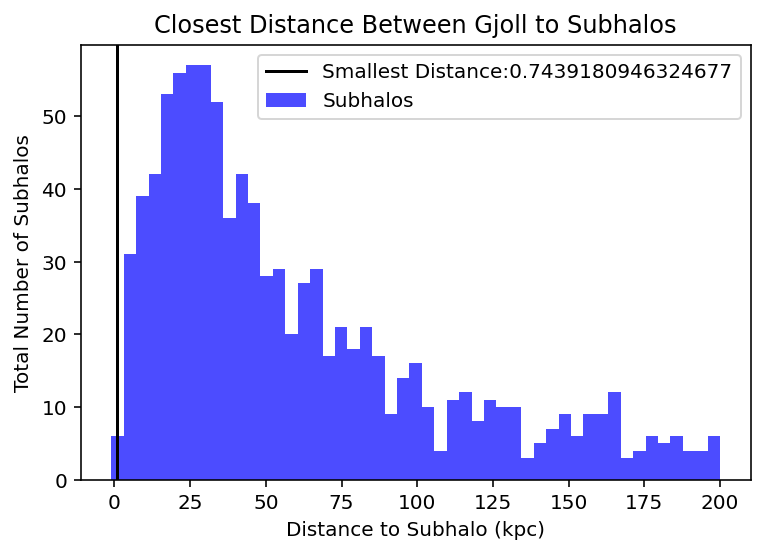

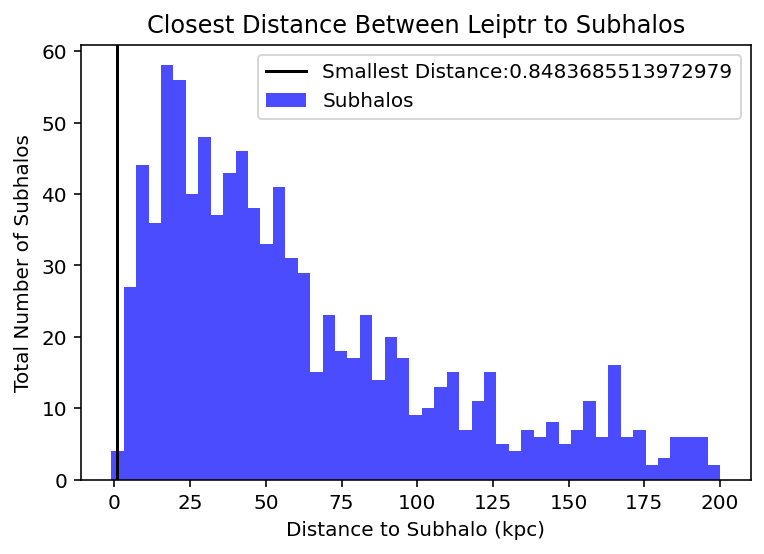

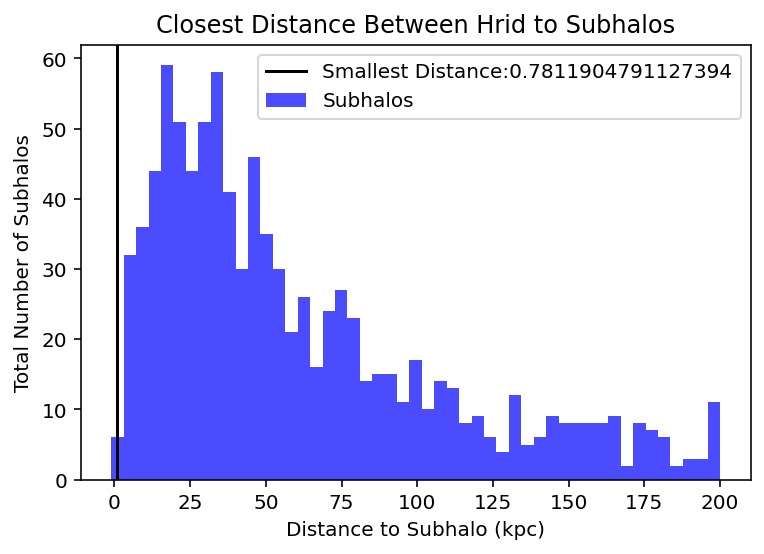

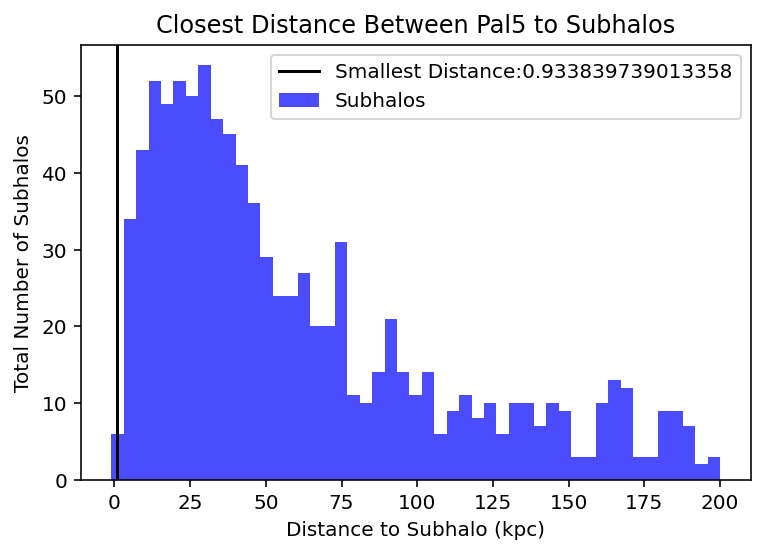

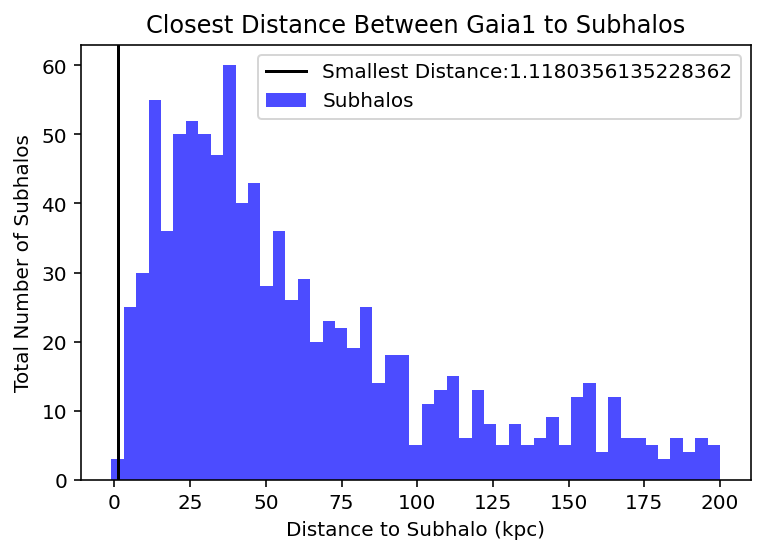

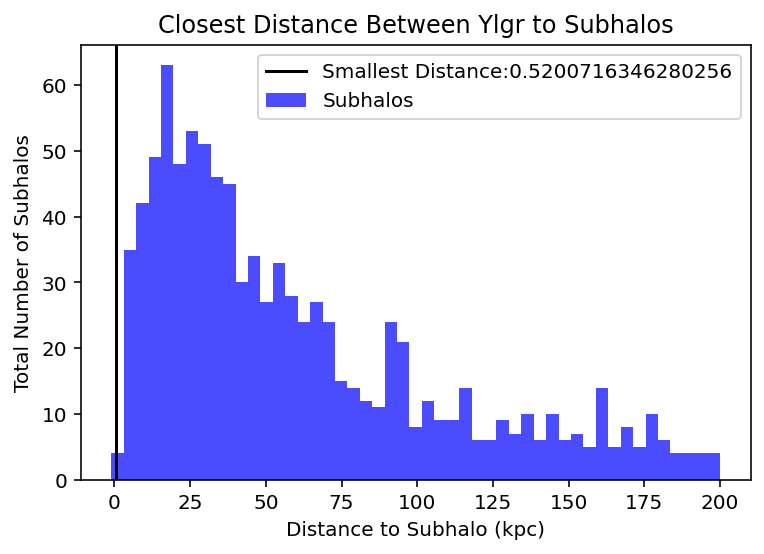

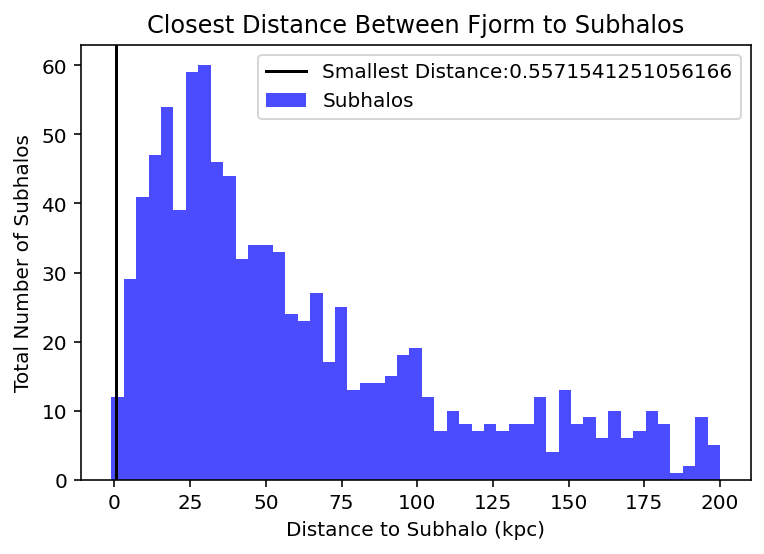

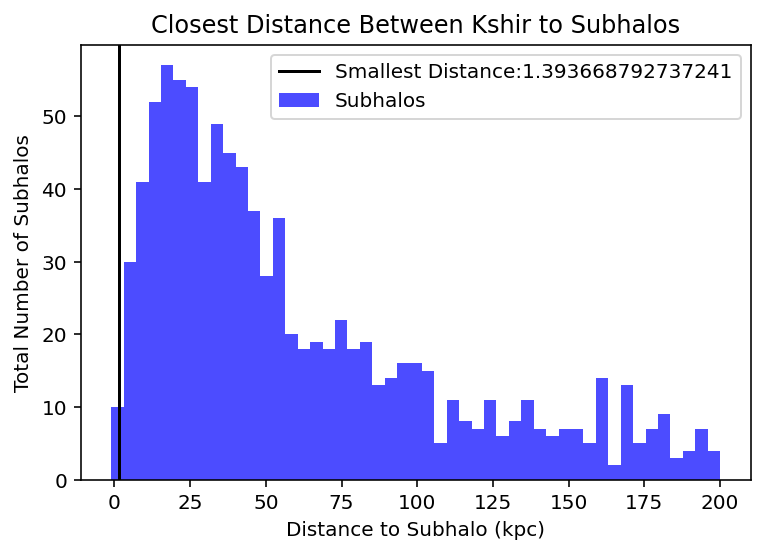

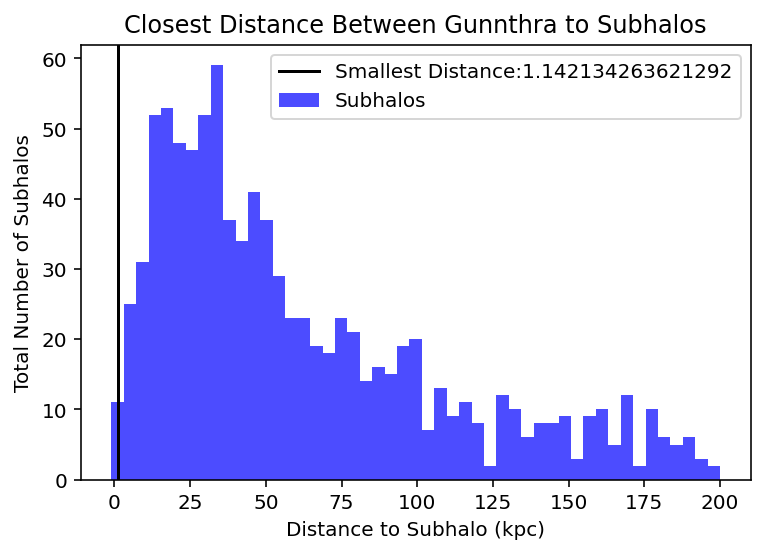

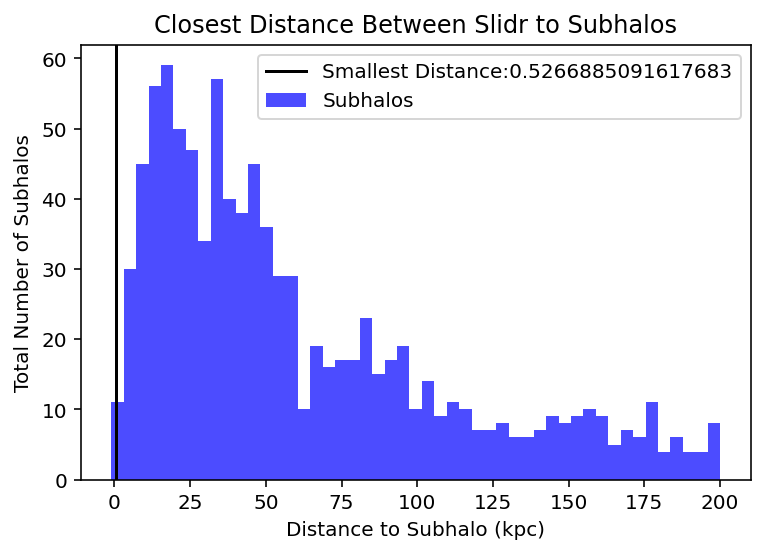

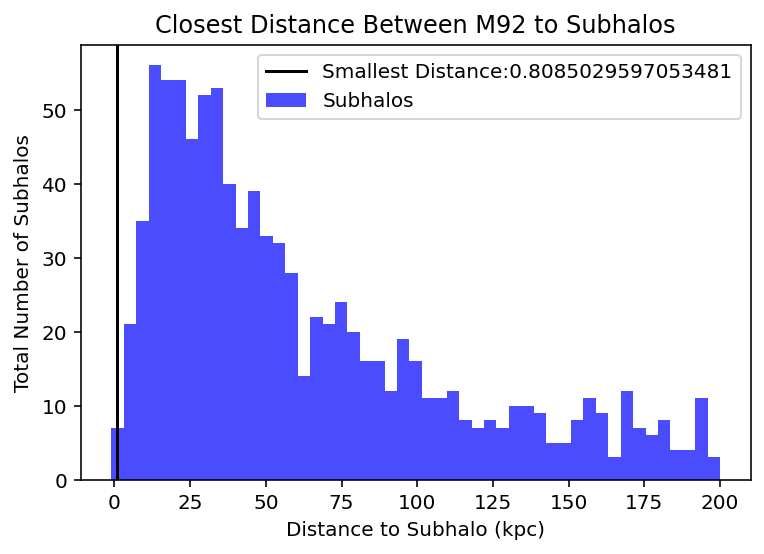

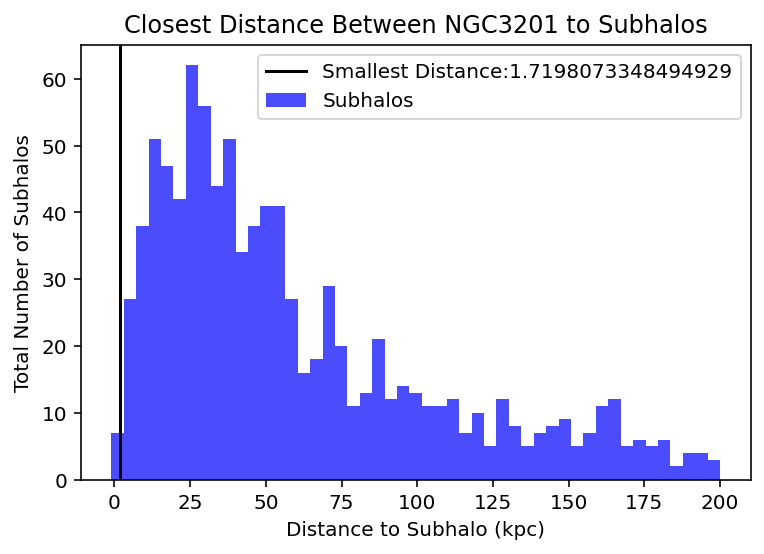

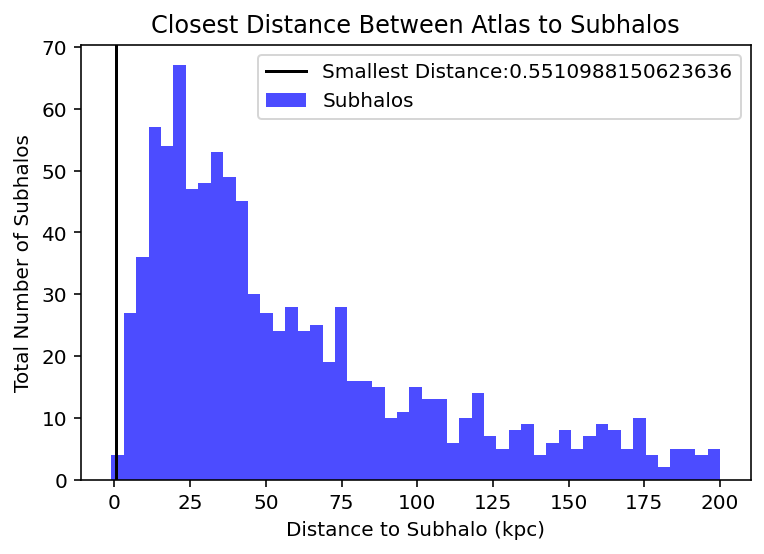

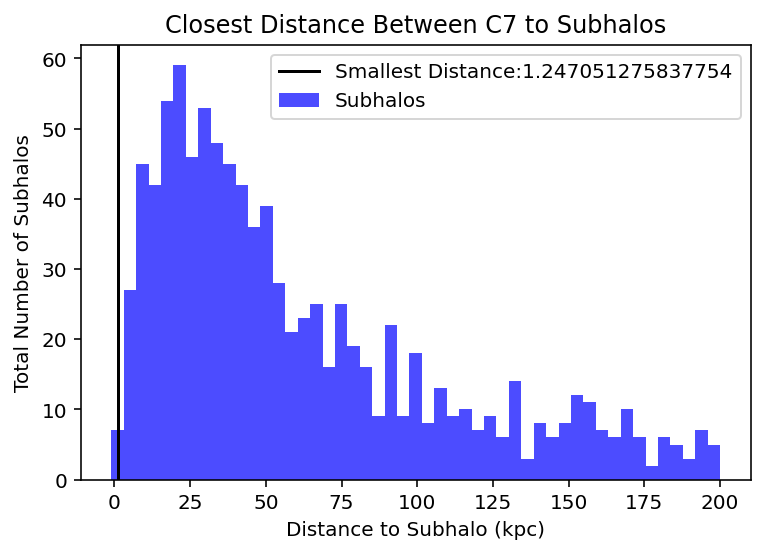

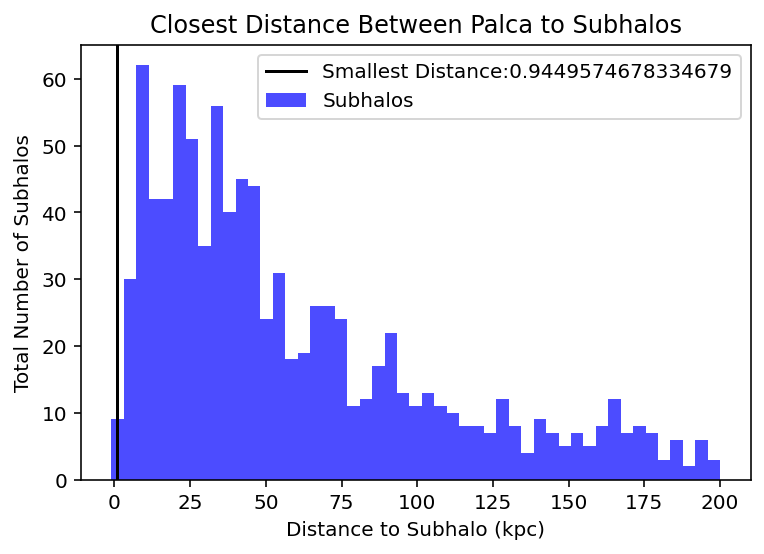

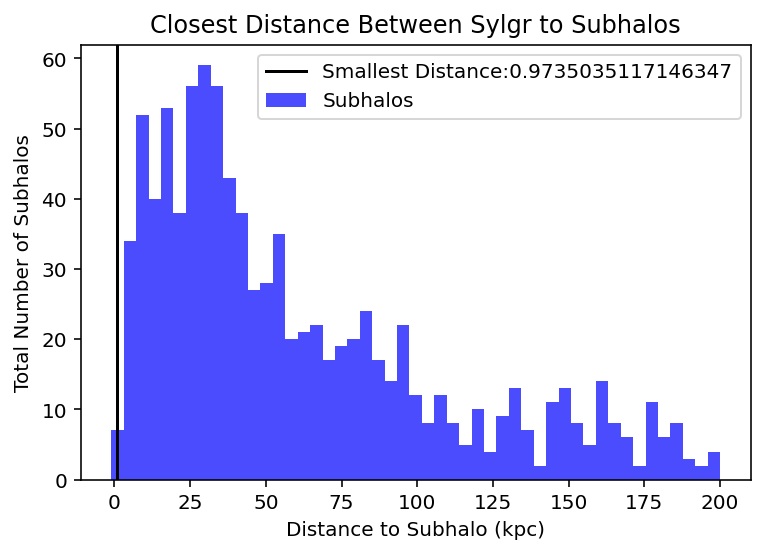

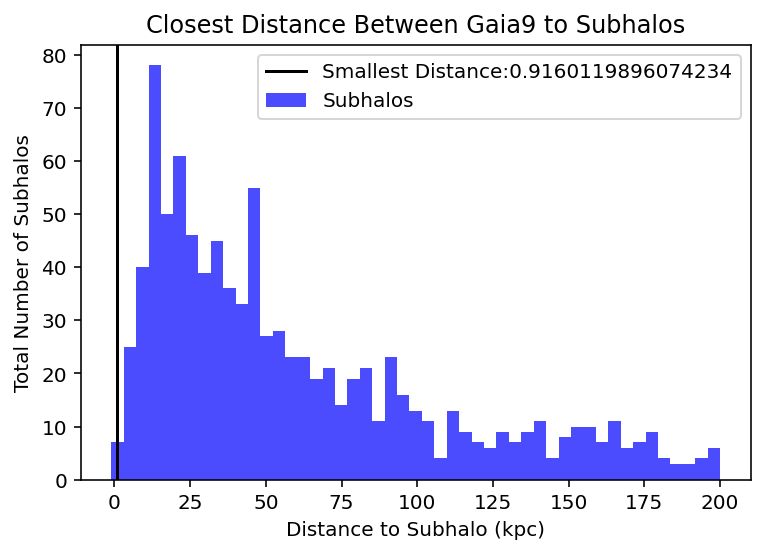

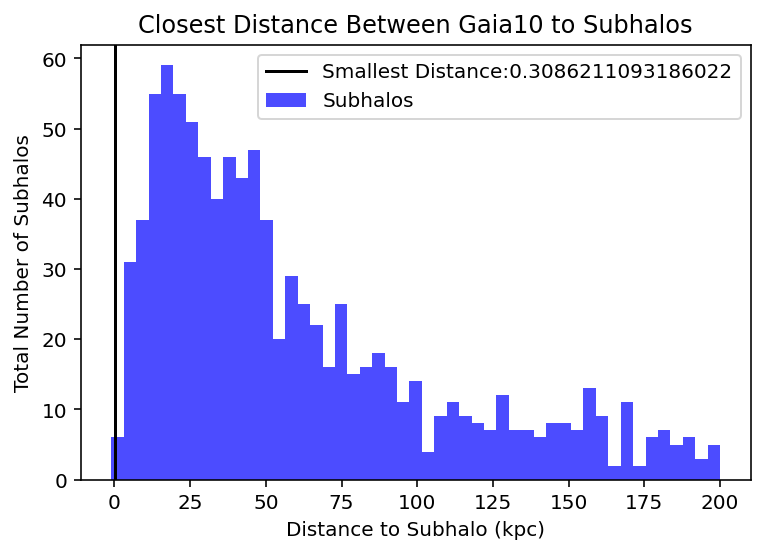

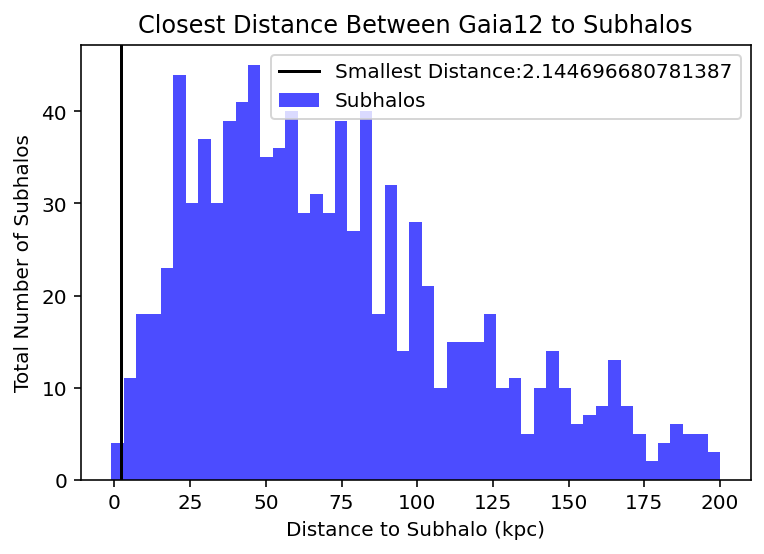

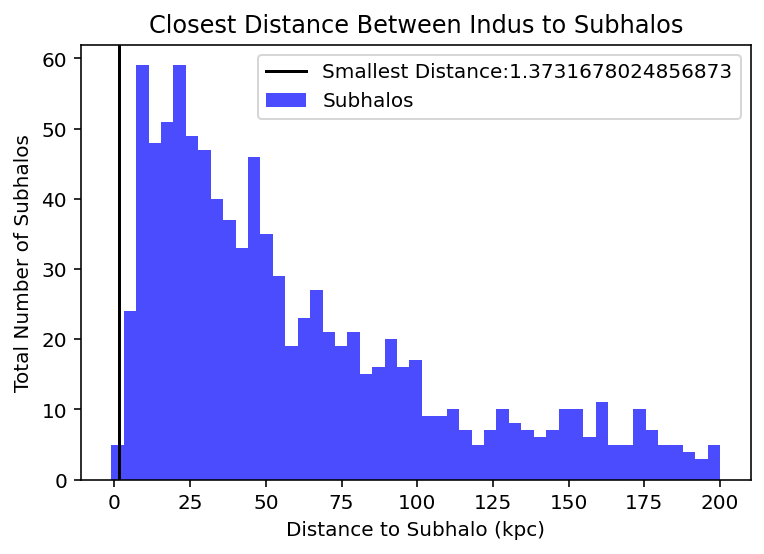

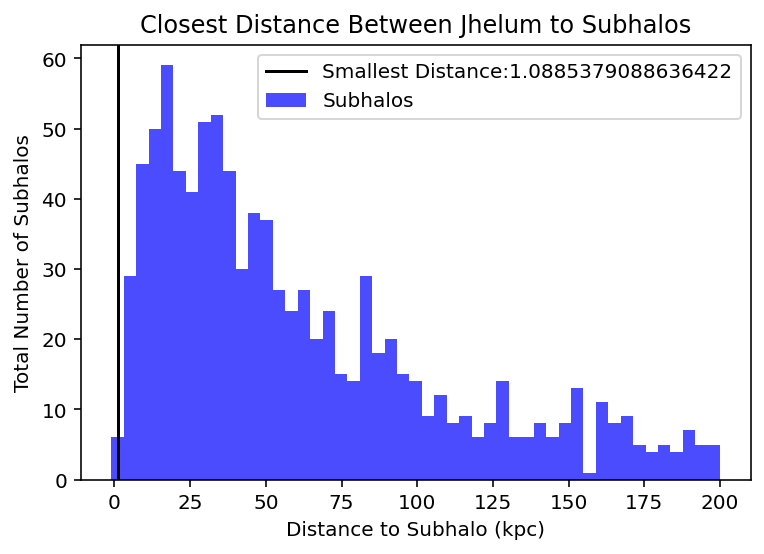

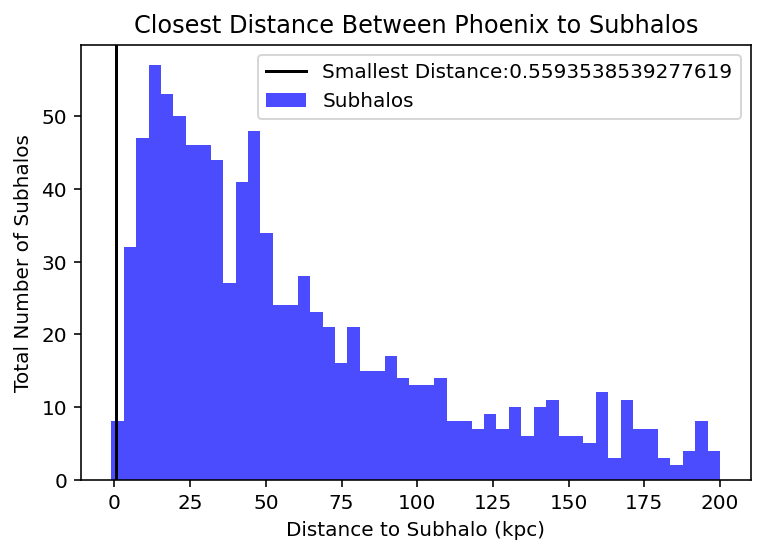

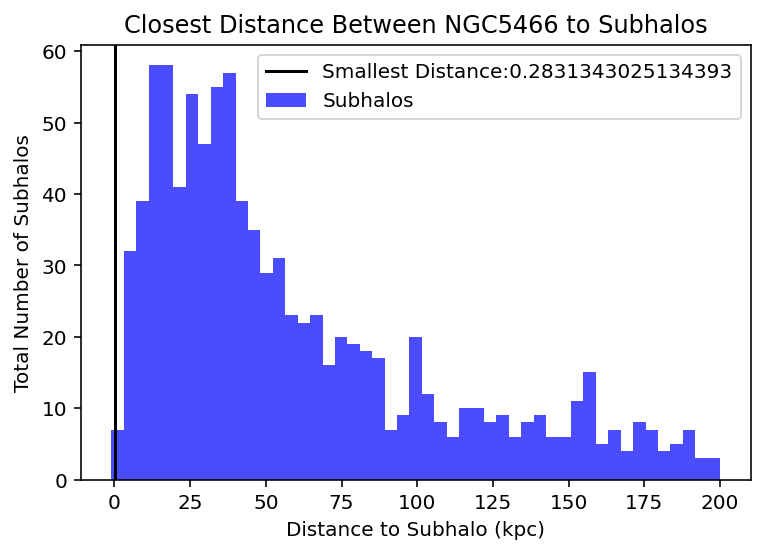

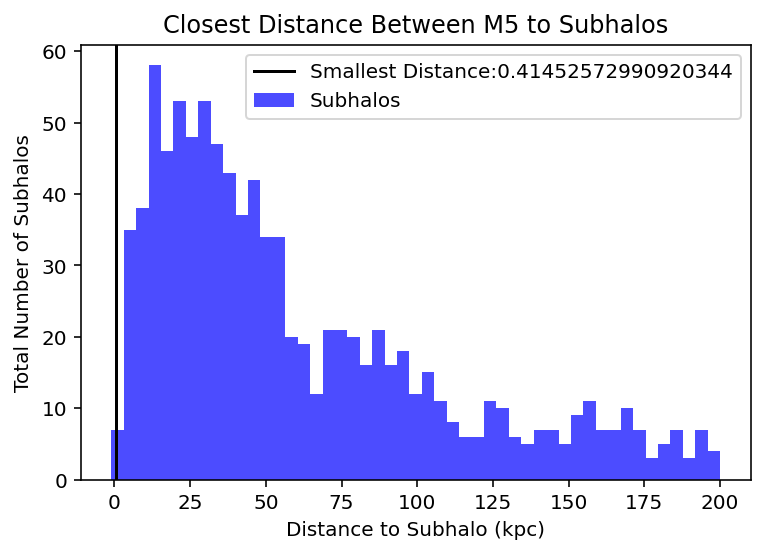

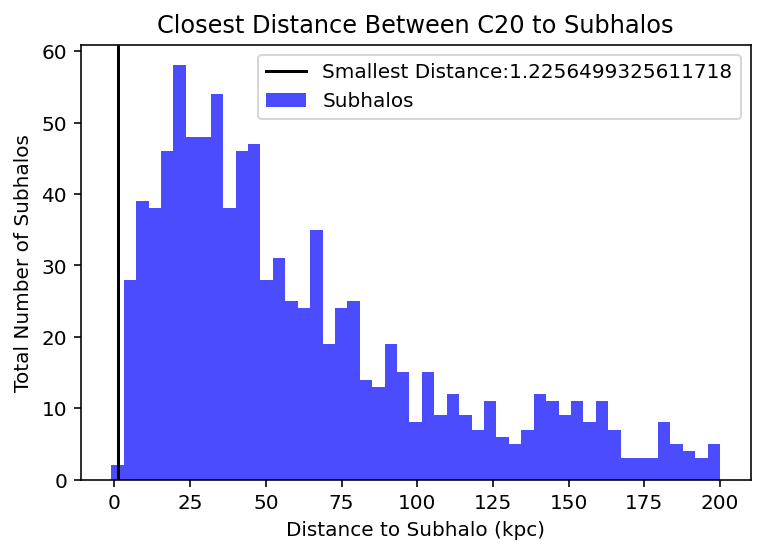

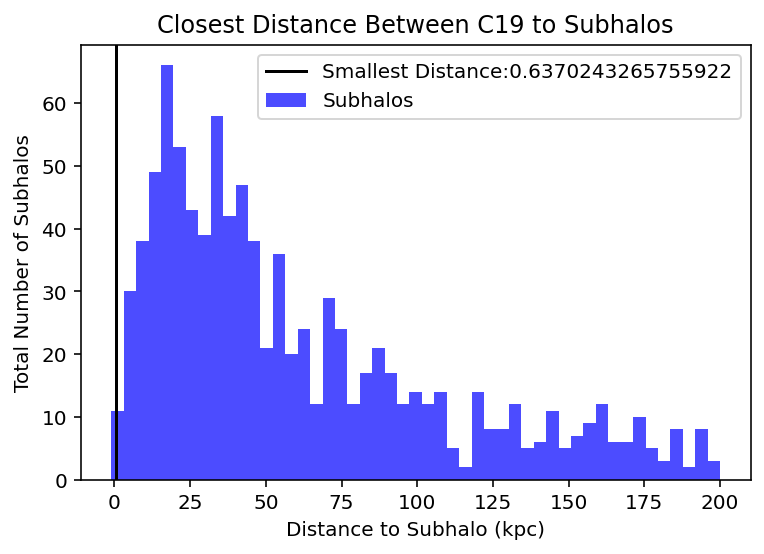

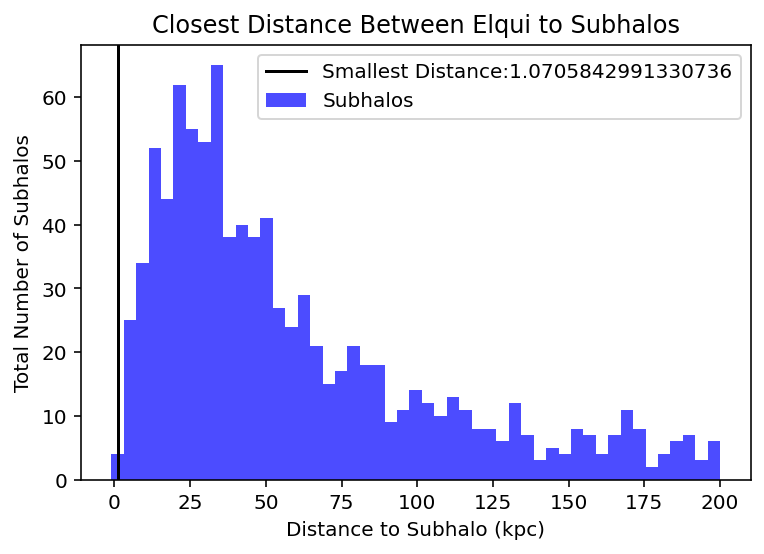

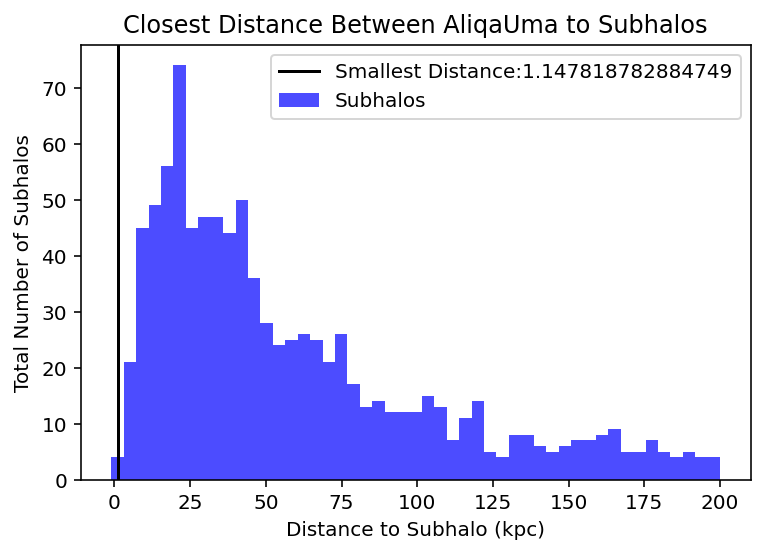

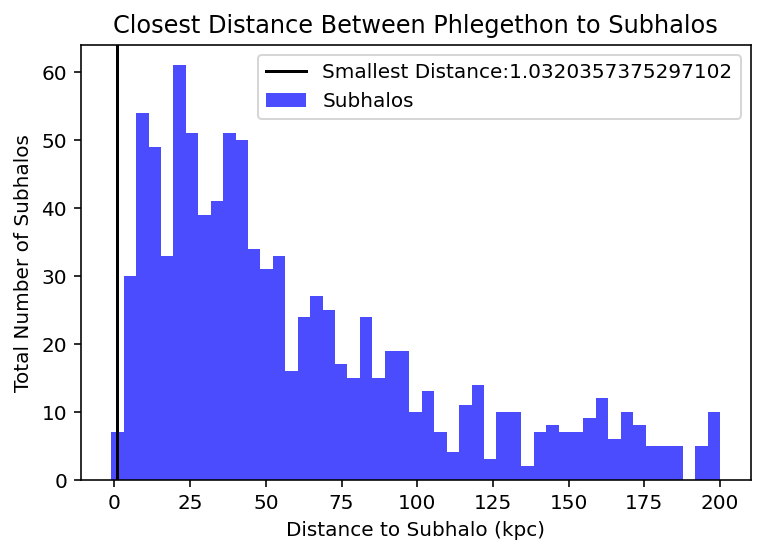

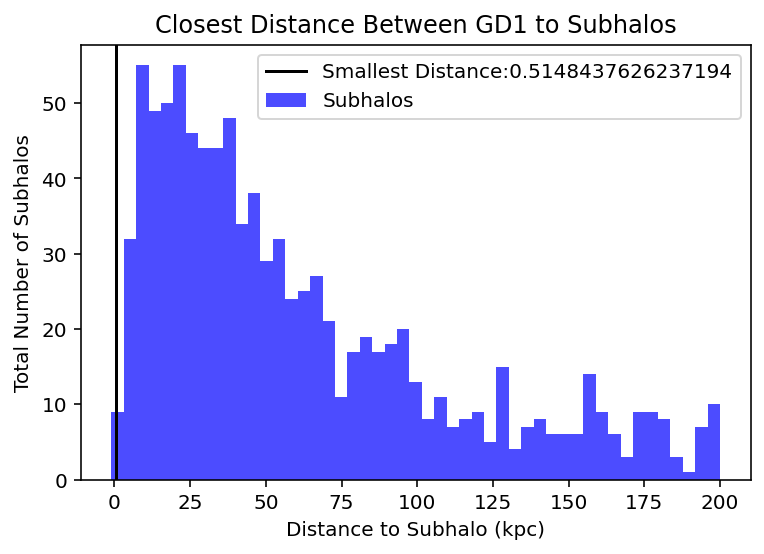

In [51]:
for i in range(len(pb)):
    plt.figure()
    plt.hist(pb.iloc[i][1:], bins=np.linspace(-1,200,50), color='blue', alpha=0.7, label='Subhalos');  
    plt.axvline(min(pb.iloc[i][1:]), color='black', label = 'Smallest Distance:'+str((min(pb.iloc[i][1:]))))
    #plt.axvline(r_apo[pb.iloc[][0]], color='black', label = "
    plt.title('Closest Distance Between '+ str(pb.iloc[i][0])+' to Subhalos') 
    plt.xlabel('Distance to Subhalo (kpc)')
    plt.ylabel('Total Number of Subhalos')
    plt.legend(loc='best')
    plt.savefig('Stream_to_Subhalo_Histograms/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)